# References


1.   [Model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2.   [Train Split Test](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
3. [Accuracy Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
4. [Dataset](https://data.mendeley.com/datasets/7dybx7wyfn/3)



In [ ]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier
import scipy.io as sio
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import os
from scipy.io import loadmat


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def moving_window(signal, window_size):
  #takes a signal and takes the average depending on the window size
  num_windows = int(len(signal) / window_size)
  output = np.zeros(num_windows).astype(np.float32)
  for i in range(num_windows-1):
    start = i * window_size
    end =  (i+1) * window_size
    output[i] = np.mean(signal[start:end])
  return output

In [ ]:
def qrs_detect(signal, fs):
  #derive from pan-tomkins qrs dection
  #takes an ecg signal and sampling frequency
  #then outputs at 1D array that contains 1 and zeros called labels
  #labels plots where QRS are located in the signal
  d1 = np.abs(np.diff(signal))
  d2 = np.abs(np.diff(signal,2))
  diff= d1[:len(d2)] + d2
  mov_avg = moving_window(diff , 10)
  thr = np.max(mov_avg)
  labels = np.zeros(len(signal))
  for i in range(len(signal)):
    if signal[i] > thr:
      labels[i] = 1
  return labels


In [ ]:
def signal_normalizer(signal):
  #takes a signal, removes the DC component, then normalizes the amplitude
  row,col = signal.shape
  ecg = np.zeros((col, row))
  for i in range(row):
    ecg[:,i] = signal[i,:] - np.mean(signal[i,:])
    ecg[:,i] = ecg[:,i]/ max(ecg[:,i])
  return ecg

In [ ]:
def load_mat_files_from_folder(folder_path):
    #takes a folder full of matlab files and stacked them in one 2D array
    # Mount Google Drive
    all_data = []  # List to store data from each file
    folder_content = os.listdir(folder_path)  # Get list of files in the folder
    mat_files = [file for file in folder_content if file.endswith('.mat')]  # Filter .mat files
    for mat_file in mat_files:
        mat_data = loadmat(folder_path + '/' + mat_file)  # Load the .mat file
        for key in mat_data.keys():
            if not key.startswith('__'):
                all_data.append(mat_data[key])
    stacked_data = np.vstack(all_data)  # Stack data into a 2D array
    return stacked_data

In [ ]:
def batch_tester(files, model):
  #takes  series of ecg files applies the model, the prints the accuracy score test
  #and plots the prediction of lowest accuracy and highest accuracy
  x,y = files.shape
  t = np.arange(x) / 360
  results = np.zeros(y)
  labels_mat = np.zeros((y,x))
  print('------------------------------')
  print('Testing has Started')
  print('------------------------------')
  for i in range(y):
    file_num = i
    unseen_data = files[:,file_num]
    unseen_labels = qrs_detect(unseen_data,fs)
    y_new = model.predict(unseen_data.reshape(-1,1))
    labels_mat[i,:] = y_new
    results[i] = int(accuracy_score(unseen_labels, y_new)*100.0)
    print("ECG Data ", (i+1), " Accuracy Score: ", int(accuracy_score(unseen_labels, y_new)*100.0), "%")
  print('------------------------------')
  print('Testing Completed')
  print('------------------------------')
  print("Number of Files Tested: ", y)
  print("Highest Accuracy Score: ", np.max(results),"%")
  print("Lowest Accuracy Score: ", np.min(results),"%")
  print("Average Accuracy Score: ", np.mean(results), "%")
  lowest_accuracy_data= np.argwhere(results == np.min(results))
  highest_accuracy_data= np.argwhere(results == np.max(results))

  plt.figure(figsize=(20,10))
  plt.subplot(1, 2, 1)
  plt.plot(t[:800], labels_mat[lowest_accuracy_data[0],:800].flatten().flatten())
  plt.plot(t[:800], files[:800,lowest_accuracy_data[0]].flatten().flatten())
  plt.legend(["Predicted QRS", "Raw ECG"], loc="lower right")
  plt.title('QRS Prediction with Lowest Accuracy')
  plt.xlabel('Time (seconds)')
  plt.ylabel('ECG')
  plt.subplot(1, 2, 2)
  plt.plot(t[:800], labels_mat[highest_accuracy_data[0],:800].flatten().flatten())
  plt.plot(t[:800], files[:800,highest_accuracy_data[0]].flatten().flatten())
  plt.legend(["Predicted QRS", "Raw ECG"], loc="lower right")
  plt.title('QRS Prediction with Highest Accuracy')
  plt.xlabel('Time (seconds)')
  plt.ylabel('ECG')


  return None



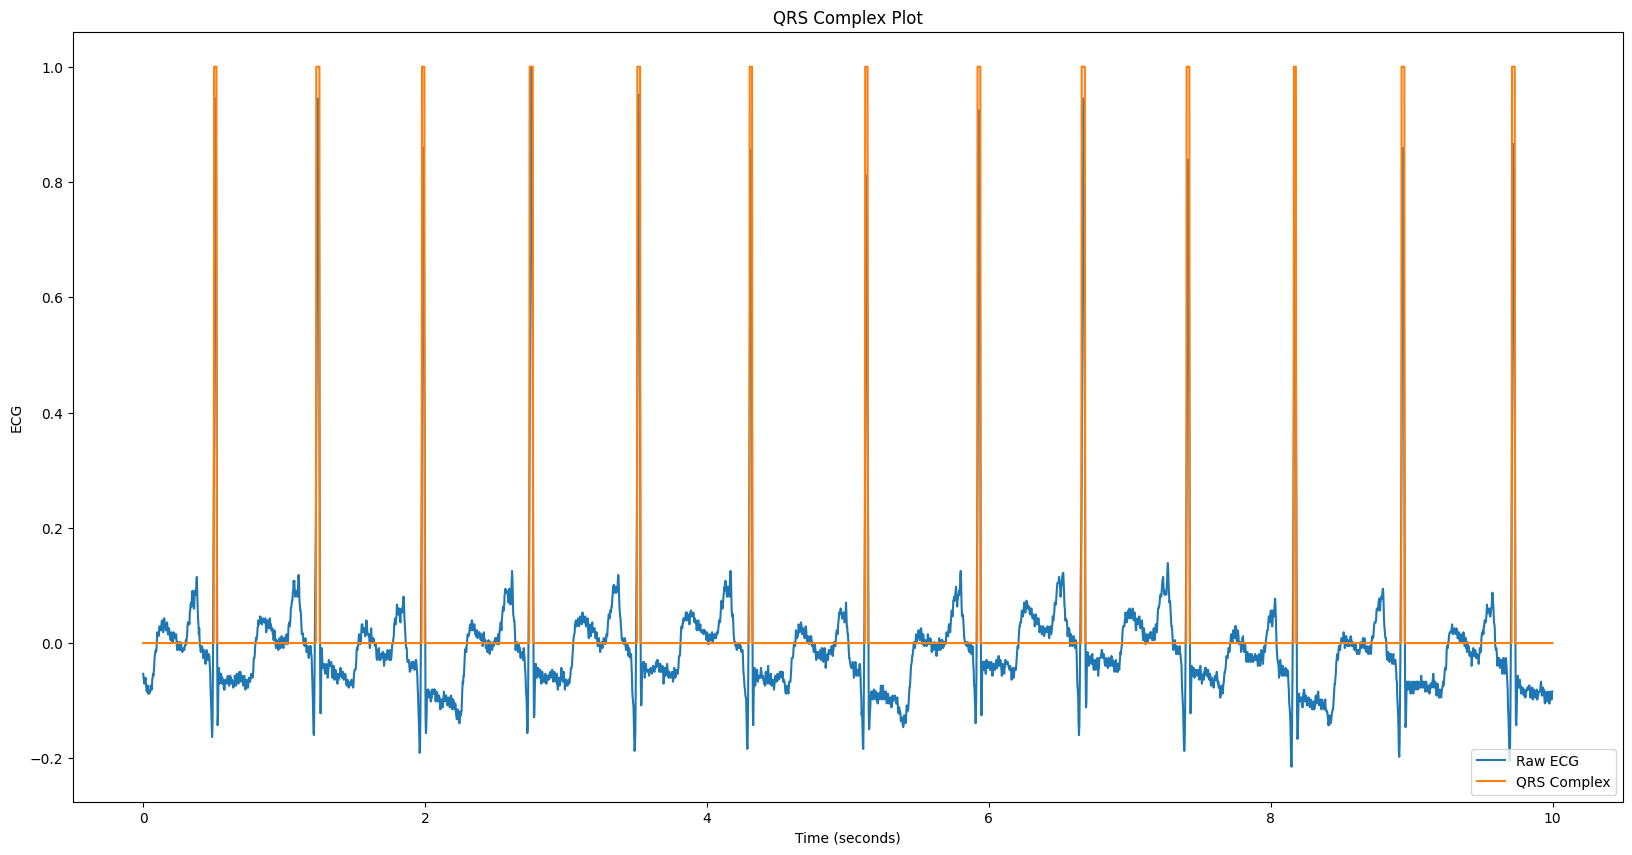

In [ ]:
sample = loadmat('/content/drive/MyDrive/EECS4643 Project/1 NSR/100m (0).mat')['val'][0]
sample_norm = sample - np.mean(sample)
sample_norm = sample_norm / max(sample_norm)
fs = 360
t = np.arange(len(sample_norm)) / fs
labels = qrs_detect(sample_norm, fs)
plt.figure(figsize=(20,10))
plt.plot(t, sample_norm, label='RAW ECG')
plt.plot(t, labels, label='QRS Complex')
plt.legend(["Raw ECG", "QRS Complex"], loc="lower right")
plt.xlabel('Time (seconds)')
plt.ylabel('ECG')
plt.title('QRS Complex Plot')
plt.show()

In [ ]:
X = sample_norm .reshape(-1,1)
y = labels
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 41) #splits the sample in datasets that we can use for training, 20% for training and the rest is for testing

In [ ]:
QRSmodel = RandomForestClassifier(n_estimators=50, random_state=41)
QRSmodel.fit(X_train, y_train)

RandomForestClassifier(n_estimators=50, random_state=41)

In [ ]:
y_pred = QRSmodel.predict(X_test)
# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.9972222222222222


Idioventricular rhythm is a slow regular ventricular rhythm with a rate of less than 50 bpm, absence of P waves, and a prolonged QRS interval.

------------------------------
Testing has Started
------------------------------
ECG Data  1  Accuracy Score:  82 %
ECG Data  2  Accuracy Score:  94 %
ECG Data  3  Accuracy Score:  94 %
ECG Data  4  Accuracy Score:  93 %
ECG Data  5  Accuracy Score:  93 %
ECG Data  6  Accuracy Score:  93 %
ECG Data  7  Accuracy Score:  93 %
ECG Data  8  Accuracy Score:  88 %
ECG Data  9  Accuracy Score:  92 %
ECG Data  10  Accuracy Score:  93 %
------------------------------
Testing Completed
------------------------------
Number of Files Tested:  10
Highest Accuracy Score:  94.0 %
Lowest Accuracy Score:  82.0 %
Average Accuracy Score:  91.5 %


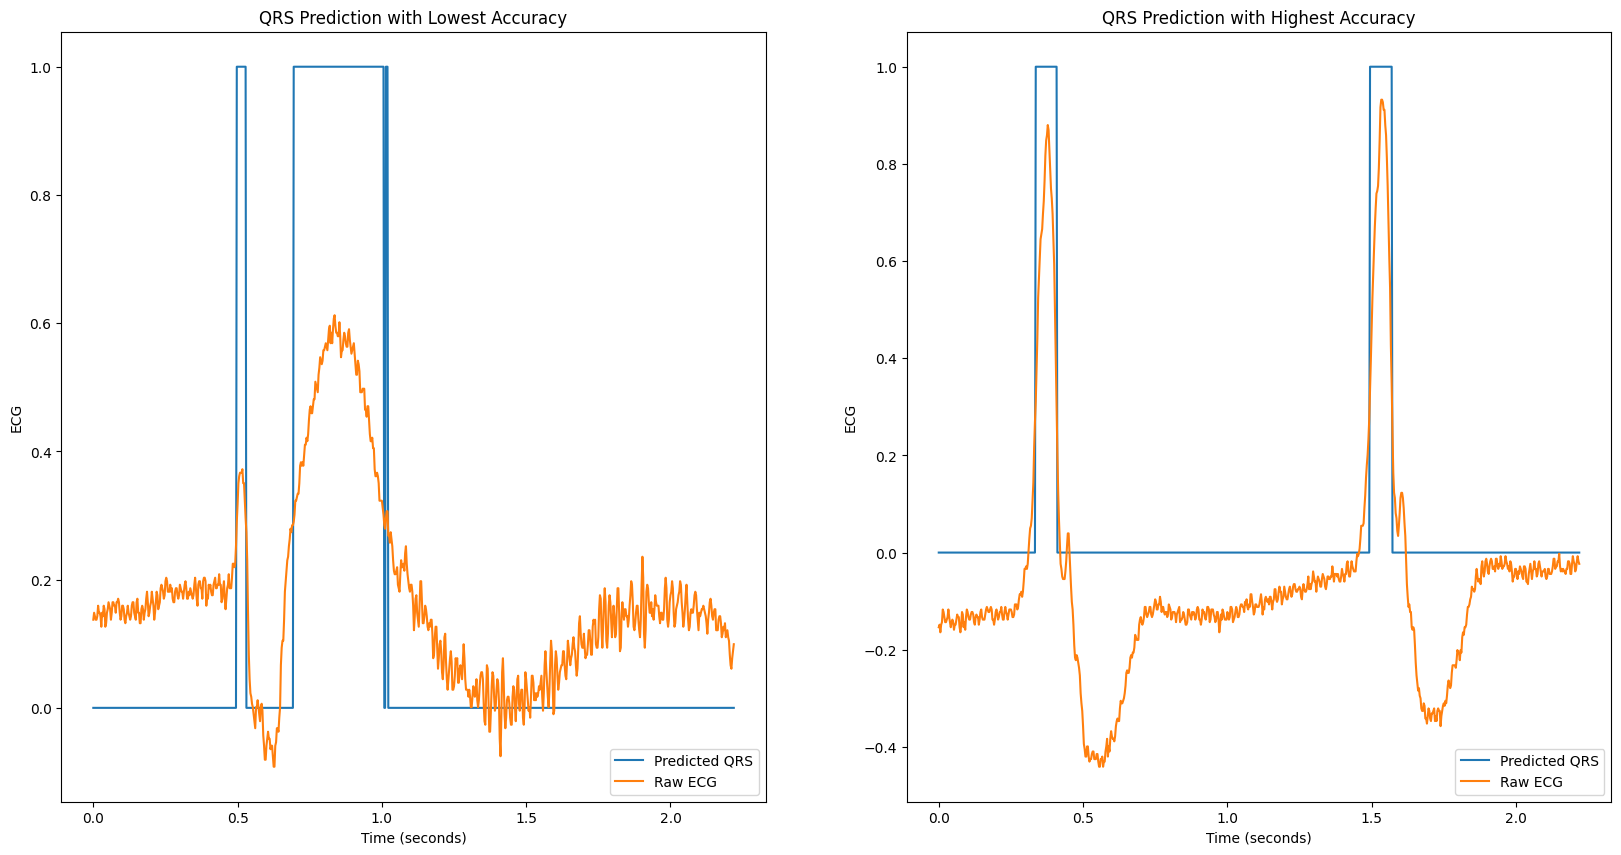

In [ ]:
ivr_path = '/content/drive/MyDrive/EECS4643 Project/11 IVR' #Idioventricular rhythm data was used
ivr = load_mat_files_from_folder(ivr_path)
ivr_norm= signal_normalizer(ivr)
batch_tester(ivr_norm, QRSmodel)

This means an ECG showing atrial fibrillation will have no visible P waves and an irregularly irregular QRS complex. The ventricular rate is frequently fast, unless the patient is on AV nodal blocking drugs such as beta-blockers or non-dihydropyridine calcium channel blockers.

------------------------------
Testing has Started
------------------------------
ECG Data  1  Accuracy Score:  98 %
ECG Data  2  Accuracy Score:  98 %
ECG Data  3  Accuracy Score:  98 %
ECG Data  4  Accuracy Score:  99 %
ECG Data  5  Accuracy Score:  98 %
ECG Data  6  Accuracy Score:  98 %
ECG Data  7  Accuracy Score:  99 %
ECG Data  8  Accuracy Score:  98 %
ECG Data  9  Accuracy Score:  99 %
ECG Data  10  Accuracy Score:  98 %
ECG Data  11  Accuracy Score:  96 %
ECG Data  12  Accuracy Score:  98 %
ECG Data  13  Accuracy Score:  99 %
ECG Data  14  Accuracy Score:  98 %
ECG Data  15  Accuracy Score:  90 %
ECG Data  16  Accuracy Score:  86 %
ECG Data  17  Accuracy Score:  98 %
ECG Data  18  Accuracy Score:  98 %
ECG Data  19  Accuracy Score:  98 %
ECG Data  20  Accuracy Score:  98 %
ECG Data  21  Accuracy Score:  98 %
ECG Data  22  Accuracy Score:  98 %
ECG Data  23  Accuracy Score:  96 %
ECG Data  24  Accuracy Score:  97 %
ECG Data  25  Accuracy Score:  98 %
ECG Data  26  Accuracy Scor

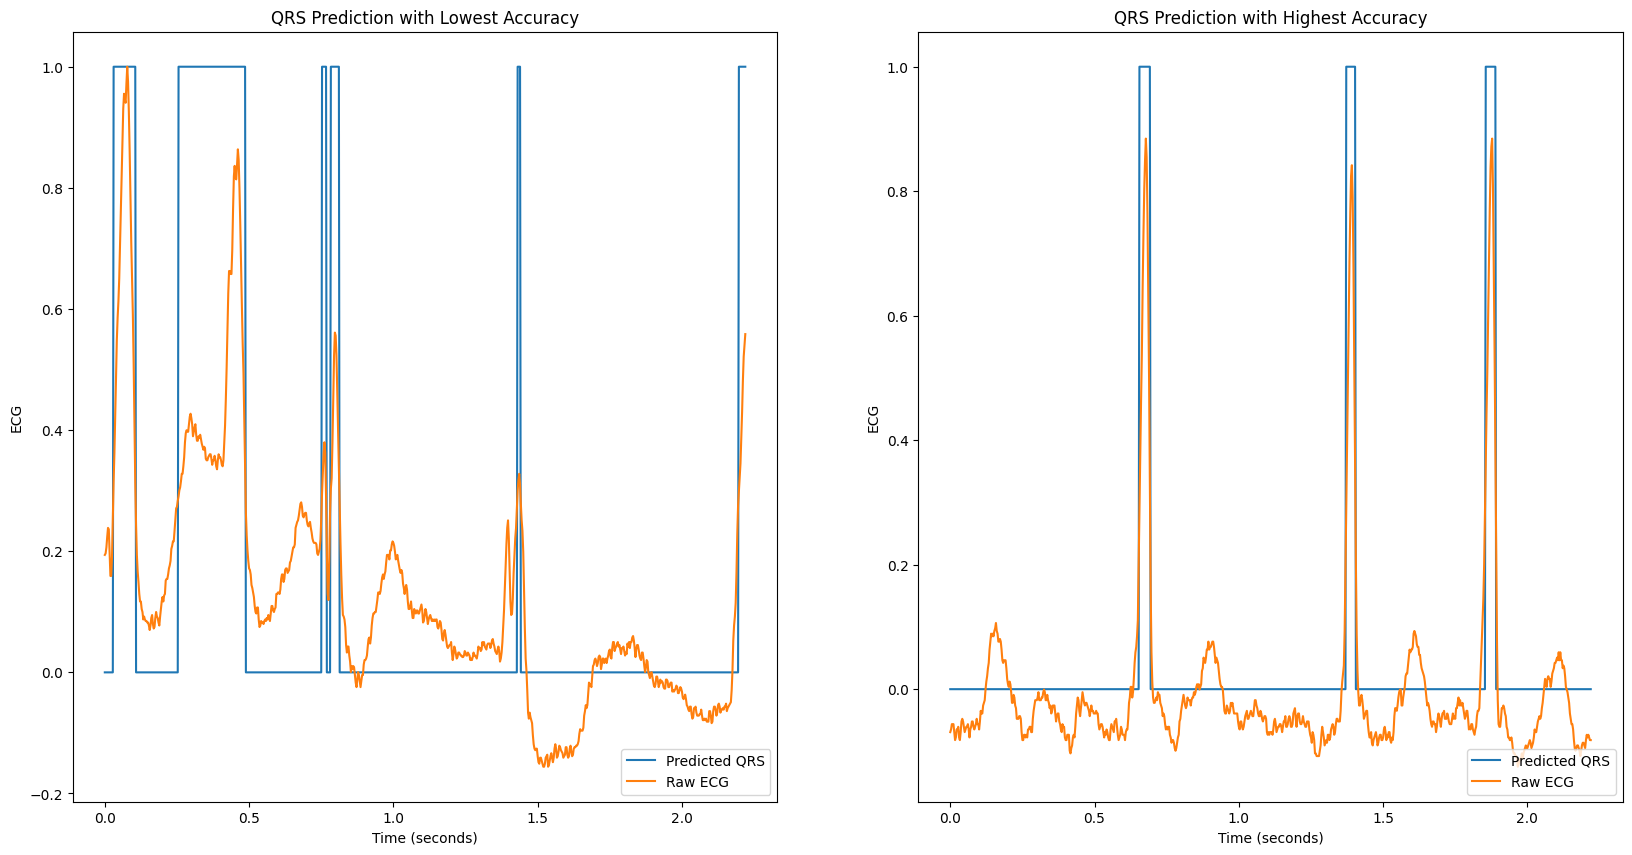

In [ ]:
afib = '/content/drive/MyDrive/EECS4643 Project/4 AFIB' #atrial fibrillation data was used
afib_files = load_mat_files_from_folder(afib)
afib_norm= signal_normalizer(afib_files)
batch_tester(afib_norm, QRSmodel)

**Normal sinus rhythm (NSR)** is the rhythm that originates from the sinus node and describes the characteristic rhythm of the healthy human heart. The rate in NSR is generally regular but will vary depending on autonomic inputs into the sinus node.Aug 10, 2022

------------------------------
Testing has Started
------------------------------
ECG Data  1  Accuracy Score:  89 %
ECG Data  2  Accuracy Score:  87 %
ECG Data  3  Accuracy Score:  79 %
ECG Data  4  Accuracy Score:  78 %
ECG Data  5  Accuracy Score:  78 %
ECG Data  6  Accuracy Score:  78 %
ECG Data  7  Accuracy Score:  78 %
ECG Data  8  Accuracy Score:  87 %
ECG Data  9  Accuracy Score:  88 %
ECG Data  10  Accuracy Score:  87 %
------------------------------
Testing Completed
------------------------------
Number of Files Tested:  10
Highest Accuracy Score:  89.0 %
Lowest Accuracy Score:  78.0 %
Average Accuracy Score:  82.9 %


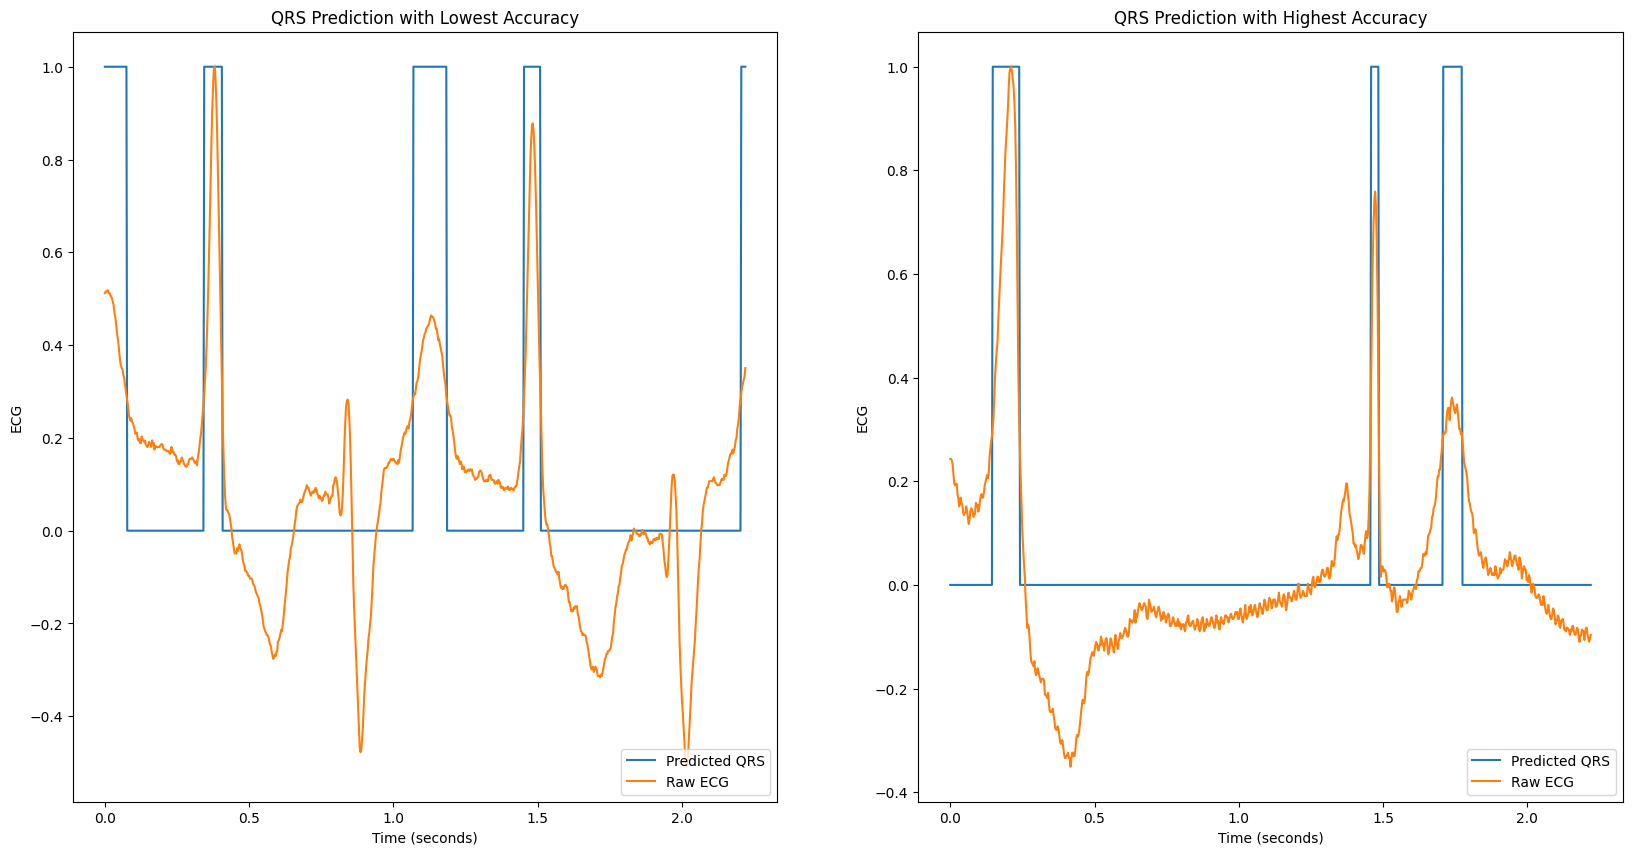

In [ ]:
vt = '/content/drive/MyDrive/EECS4643 Project/10 VT' #ventricular tachycardia ECG data was used
vt_files = load_mat_files_from_folder(vt)
vt_norm= signal_normalizer(vt_files)
batch_tester(vt_norm, QRSmodel)

------------------------------
Testing has Started
------------------------------
ECG Data  1  Accuracy Score:  99 %
ECG Data  2  Accuracy Score:  99 %
ECG Data  3  Accuracy Score:  99 %
ECG Data  4  Accuracy Score:  99 %
ECG Data  5  Accuracy Score:  99 %
ECG Data  6  Accuracy Score:  99 %
ECG Data  7  Accuracy Score:  99 %
ECG Data  8  Accuracy Score:  99 %
ECG Data  9  Accuracy Score:  99 %
ECG Data  10  Accuracy Score:  99 %
ECG Data  11  Accuracy Score:  99 %
ECG Data  12  Accuracy Score:  97 %
ECG Data  13  Accuracy Score:  99 %
ECG Data  14  Accuracy Score:  98 %
ECG Data  15  Accuracy Score:  97 %
ECG Data  16  Accuracy Score:  97 %
ECG Data  17  Accuracy Score:  97 %
ECG Data  18  Accuracy Score:  97 %
ECG Data  19  Accuracy Score:  98 %
ECG Data  20  Accuracy Score:  97 %
ECG Data  21  Accuracy Score:  97 %
ECG Data  22  Accuracy Score:  99 %
ECG Data  23  Accuracy Score:  99 %
ECG Data  24  Accuracy Score:  99 %
ECG Data  25  Accuracy Score:  99 %
ECG Data  26  Accuracy Scor

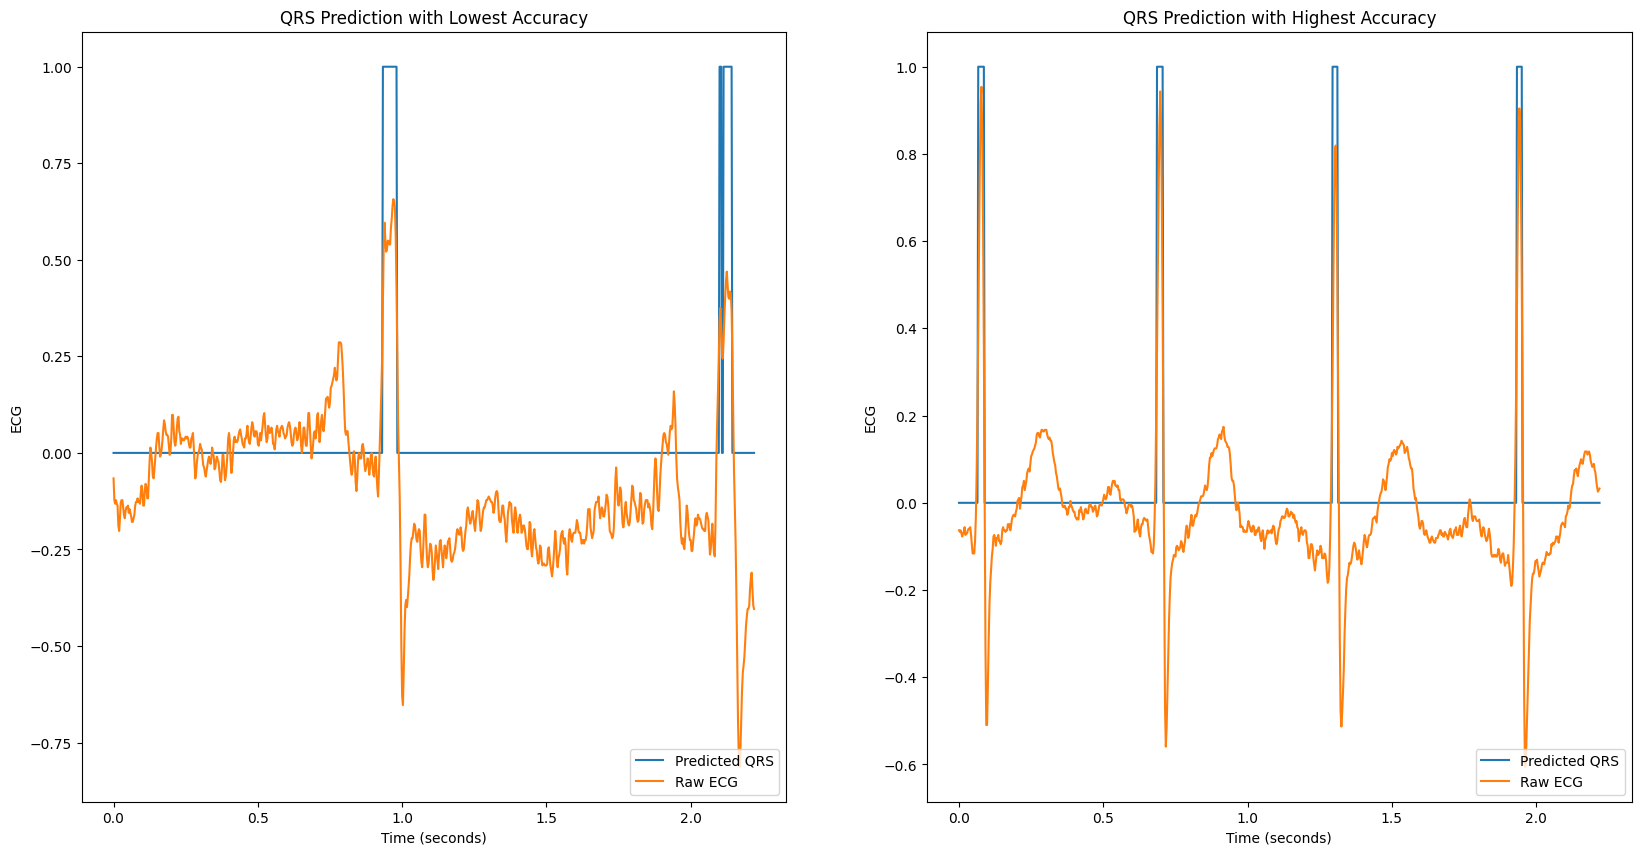

In [ ]:
nsr_path = '/content/drive/MyDrive/EECS4643 Project/1 NSR' #Normal sinus rhythm (NSR)
nsr = load_mat_files_from_folder(nsr_path)
nsr_norm= signal_normalizer(nsr)
batch_tester(nsr_norm, QRSmodel)